# Directory Information

In [1]:
import os 
# ------------------------ Examine the Current Directory and Files Within -----------#
current_directory = os.getcwd() # Let us get our current working directory
files = os.listdir()
# ------------------------ Display the files with -----------------------------------# 
print('~'*50) # Line 
print('Current Working Directory:', current_directory) 
print('~'*50) # Line 
for file in files:
    print(file) 
    print('~'*50)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Current Working Directory: /u/project/cluo/chunter/MODELS/Base_Models_HVG
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Autoencoder_Marker_Genes.ipynb
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
.ipynb_checkpoints
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
VAE_Marker_Genes.ipynb
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GMM_VAE_Marker_Genes.ipynb
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GMM_VAE_HVG_LVG.ipynb
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
CARDEC_HVG_Variational_Autoencoder.ipynb
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Library Needed

In [2]:
# Library Needed for Single-Cell Analysis
#!pip install --quiet scanpy
import scanpy as sc
import scvi
import warnings
# Library Needed for Plotting / Data Analysis
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# Library Needed for Autoencoder
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Lambda, Input, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras import metrics
import tensorflow as tf
from sklearn.model_selection import train_test_split

/u/home/c/chunter/.local/lib/python3.9/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
2023-07-24 09:29:18.563997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load in the Dataset

In [7]:
import scanpy as sc
# ------------------------------Load in the Data --------------------------------------------------------------------- #
path = '/u/project/cluo/heffel/joint_v4/CTX_all_ages_mCG-CH.h5ad'
adata = sc.read(path) # Use scanpy to read in our .h5ad object
# ------------------------------View the Data------------------------------------------------------------------------ #
print('~'*75) # Line
print('adata general structure: \n\n ', adata) # Print the structure of our AnnData object
print('~'*75) # Line

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
adata general structure: 

  AnnData object with n_obs × n_vars = 29691 × 44639
    obs: 'Sample', 'region', 'mCCC/CCC', 'mCH/CH', 'mCG/CG', 'L2', 'L3', 'age_groups', 'temp_clust', 'log2_age', 'age', 'leiden', 'L5', 'mSample', 'TotalInt', 'age_groups+', 'L4', 'L1', 'oldL2', 'oldL3', 'oldL4', 'oldmCCC/CCC', 'oldmCH/CH', 'oldmCG/CG', 'oldSample', 'oldregion', 'oldage_groups', 'oldTotalInt', 'sL3', 'asL3'
    uns: 'L2_colors', 'L5_colors', 'age_groups_colors', 'asL3_colors', 'leiden', 'neighbors', 'pca', 'region_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Collect Top Marker Genes

The `rank_genes_groups(adata, 'L3', n_genes=20)` function will return differential expression results with the top ranked genes that are differentially expressed between the `L3` cell level annotations.



In [8]:
import warnings
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata, 'L4', n_genes = 20) # Rank genes using L3 cell annotation
markers = [] # Empty list where we will store our marker genes
for i in range(27): # i [rank_genes_groups] iterates through 27 gene groups 
    for j in range(20): # [j] [names] iterates through 20 genes of interest for each group in [j]
        if adata.uns['rank_genes_groups']['names'][j][i] not in markers: #  If gene in is not in markers 
            markers.append(adata.uns['rank_genes_groups']['names'][j][i]) # then append gene 
print('-'*50)                  
print(markers[1:5]) # display the first five elements of our markers list
print('-'*50)

--------------------------------------------------
['MIR99AHG_CG', 'MSRA_CG', 'MAP1B_CG', 'RAB6B_CG']
--------------------------------------------------


In [9]:
adata=adata[:,markers]
print('~'*75) # Line
print(adata)
print('~'*75) # Line

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
View of AnnData object with n_obs × n_vars = 29691 × 255
    obs: 'Sample', 'region', 'mCCC/CCC', 'mCH/CH', 'mCG/CG', 'L2', 'L3', 'age_groups', 'temp_clust', 'log2_age', 'age', 'leiden', 'L5', 'mSample', 'TotalInt', 'age_groups+', 'L4', 'L1', 'oldL2', 'oldL3', 'oldL4', 'oldmCCC/CCC', 'oldmCH/CH', 'oldmCG/CG', 'oldSample', 'oldregion', 'oldage_groups', 'oldTotalInt', 'sL3', 'asL3'
    uns: 'L2_colors', 'L5_colors', 'age_groups_colors', 'leiden', 'neighbors', 'pca', 'region_colors', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [10]:
x = np.array(adata.X)
x_train, x_test = train_test_split(x, test_size=0.33, random_state=42,shuffle=True)
print('-'*50)
print('input_dim = ',(x_train.shape[1], ))
print('-'*50)

--------------------------------------------------
input_dim =  (255,)
--------------------------------------------------


# Build Base Autoencoder

In [11]:
from keras import layers

latent_dim = 165

class BaseAutoencoder(Model):
    def __init__(self, latent_dim, callback=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5),
                loss_function=tf.keras.losses.MeanSquaredError()):
        super(BaseAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.callback = callback
        self.loss_function = loss_function
#=====================Encoder============================#
        self.encoder = tf.keras.Sequential([
            layers.Dense(300, activation='relu'),
            layers.Dense(200, activation='relu'),
            layers.Dense(180, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
#=====================Decoder============================#
        self.decoder = tf.keras.Sequential([
            layers.Dense(latent_dim, activation='relu'),
            layers.Dense(x_train.shape[1], activation='linear')
        ])
#=================Connect Encoder & Decoder==============#
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded
#=================Connect Autoencoder and Latent Dimension=============#
autoencoder = BaseAutoencoder(latent_dim)

loss_fn = tf.keras.losses.MeanSquaredError()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

autoencoder.compile(optimizer=optimizer, loss=loss_fn)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = autoencoder.fit(x_train,x_train,
                          epochs=100, batch_size=15, validation_data=(x_test, x_test), callbacks = [callback])

Epoch 1/100
1327/1327 [==============================] - 8s 5ms/step - loss: 0.0231 - val_loss: 0.0164
Epoch 2/100
1327/1327 [==============================] - 6s 5ms/step - loss: 0.0150 - val_loss: 0.0141
Epoch 3/100
1327/1327 [==============================] - 7s 5ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 4/100
1327/1327 [==============================] - 6s 5ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 5/100
1327/1327 [==============================] - 6s 5ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 6/100
1327/1327 [==============================] - 6s 5ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 7/100
1327/1327 [==============================] - 6s 5ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 8/100
1327/1327 [==============================] - 6s 5ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 9/100
1327/1327 [==============================] - 6s 5ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 10/100
1327/1327 [==============================] - 6s 5ms/step - l

Epoch 80/100
1327/1327 [==============================] - 7s 5ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 81/100
1327/1327 [==============================] - 7s 5ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 82/100
1327/1327 [==============================] - 6s 5ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 83/100
1327/1327 [==============================] - 7s 5ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 84/100
1327/1327 [==============================] - 6s 5ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 85/100
1327/1327 [==============================] - 7s 5ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 86/100
1327/1327 [==============================] - 7s 5ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 87/100
1327/1327 [==============================] - 7s 5ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 88/100
1327/1327 [==============================] - 7s 5ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 89/100
1327/1327 [==============================] - 6s 5ms

# Visualize the Training Loss vs. the Validation Loss

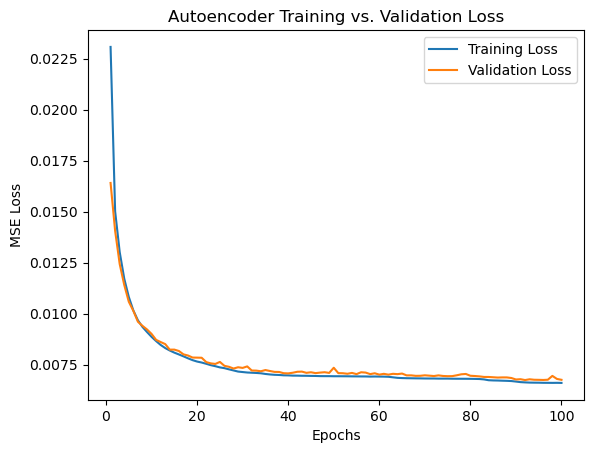

<Figure size 640x480 with 0 Axes>

In [14]:
# --------- Plot our Autoencoder Training Loss and Validation Loss ------- # 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
#---------- Plot Settings ----------#
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Autoencoder Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()
plt.savefig('Autoencoder_Highly_Variable_Loss_Plot.png')

# View the Reconstructed Data from Model

In [1]:
Latent_space = autoencoder.encoder.predict(X_train)
Latent_space = pd.DataFrame(Latent_space)
Latent_space = sc.AnnData(Latent_space)
Latent_space.write('Autoencoder_Latent_Space_Highly_Variable_Features.h5ad')

NameError: name 'autoencoder' is not defined

In [21]:
adata

AnnData object with n_obs × n_vars = 29691 × 255
    obs: 'Sample', 'region', 'mCCC/CCC', 'mCH/CH', 'mCG/CG', 'L2', 'L3', 'age_groups', 'temp_clust', 'log2_age', 'age', 'leiden', 'L5', 'mSample', 'TotalInt', 'age_groups+', 'L4', 'L1', 'oldL2', 'oldL3', 'oldL4', 'oldmCCC/CCC', 'oldmCH/CH', 'oldmCG/CG', 'oldSample', 'oldregion', 'oldage_groups', 'oldTotalInt', 'sL3', 'asL3'
    uns: 'L2_colors', 'L5_colors', 'age_groups_colors', 'leiden', 'neighbors', 'pca', 'region_colors', 'umap', 'rank_genes_groups', 'L4_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [27]:
reconstructed_adata

AnnData object with n_obs × n_vars = 29691 × 255

In [26]:
import pandas as pd
import scanpy as sc

# Assuming you have already reconstructed the data as described in your question

# Step 1: Reconstruct the data
reconstructed = autoencoder.encoder.predict(adata.X)
reconstructed_1 = autoencoder.decoder.predict(reconstructed)

# Step 2: Create a pandas DataFrame from the reconstructed data
reconstructed_df = pd.DataFrame(reconstructed_1) # Not using right now: , columns=adata.var_names, index=adata.obs_names
 
# Step 3: Create an AnnData object from the DataFrame
reconstructed_adata = sc.AnnData(reconstructed_df)
reconstructed_adata
# Step 4: Save the AnnData object as an h5ad file
reconstructed_adata.write("Autoencoder_Reconstructed_Highly_Variable_Features.h5ad")


928/928 [==============================] - 1s 1ms/step


# Run umap on Reconstructed Data

In [25]:
import pandas as pd
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Assuming you have already reconstructed the data as described in your question

# Step 1: Reconstruct the data
reconstructed = autoencoder.encoder.predict(adata.X)
reconstructed_1 = autoencoder.decoder.predict(reconstructed)

# Step 2: Create a pandas DataFrame from the reconstructed data
reconstructed_df = pd.DataFrame(reconstructed_1, columns=adata.var_names, index=adata.obs_names)

# Step 3: Create an AnnData object from the DataFrame
reconstructed_adata = sc.AnnData(reconstructed_df)

# Step 4: Perform clustering on the reconstructed data using Louvain or Leiden
sc.pp.neighbors(reconstructed_adata)
sc.tl.leiden(reconstructed_adata)

# Step 5: Compare the clustering results with the L4 annotations in the original adata
original_l4_annotations = adata.obs['L4']
reconstructed_clusters = reconstructed_adata.obs['leiden']  # Replace 'louvain' with the actual cluster key

# Use metrics like Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI)
ari = adjusted_rand_score(original_l4_annotations, reconstructed_clusters)
nmi = normalized_mutual_info_score(original_l4_annotations, reconstructed_clusters)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)


928/928 [==============================] - 1s 1ms/step
         Falling back to preprocessing with `sc.pp.pca` and default params.


ValueError: Input contains NaN

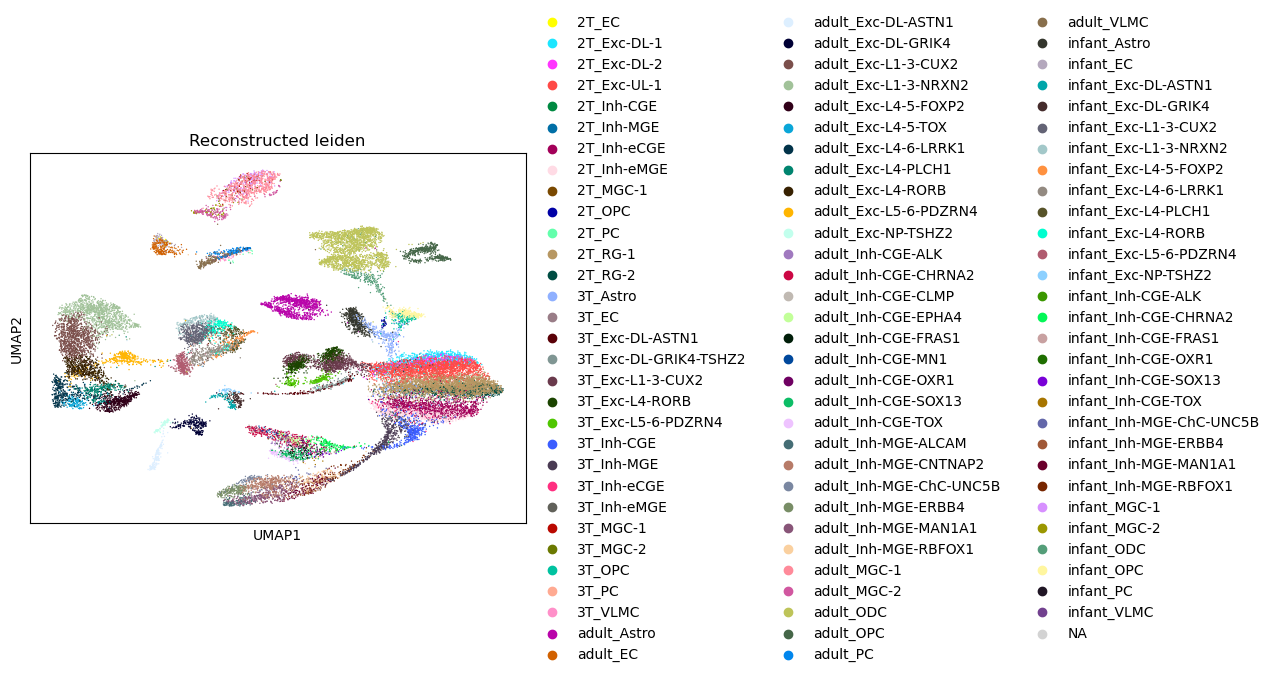

AttributeError: 'numpy.ndarray' object has no attribute 'is_view'

In [17]:
#================Original data=================#

sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'L4', title='Reconstructed leiden')

In [20]:
import pandas as pd
import scanpy as sc
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Assuming you have already reconstructed the data as described in your question
# Assuming you have already performed clustering on the reconstructed data and stored L4 annotations in 'L4_reconstructed' column

# Step 1: Retrieve L4 annotations from the original adata
original_l4_annotations = adata.obs['L4']

# Step 2: Retrieve L4 annotations from the reconstructed data
reconstructed_l4_annotations = reconstructed_adata.obs['L4_reconstructed']

# Step 3: Compare the L4 annotations using evaluation metrics
accuracy = accuracy_score(original_l4_annotations, reconstructed_l4_annotations)
f1 = f1_score(original_l4_annotations, reconstructed_l4_annotations, average='weighted')
conf_matrix = confusion_matrix(original_l4_annotations, reconstructed_l4_annotations)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


KeyError: 'L4_reconstructed'

# Run PCA on the Reconstructed Data

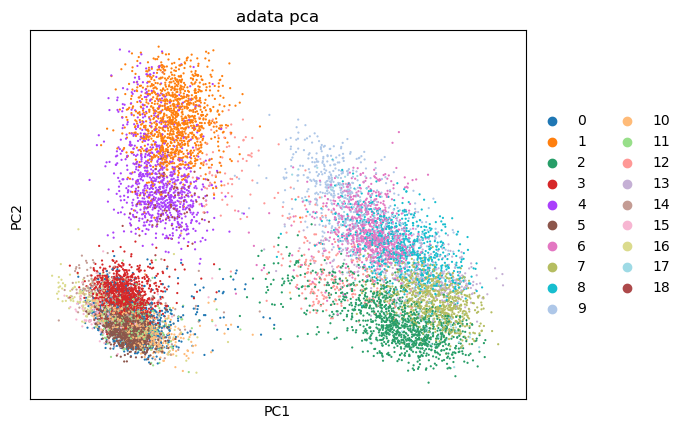

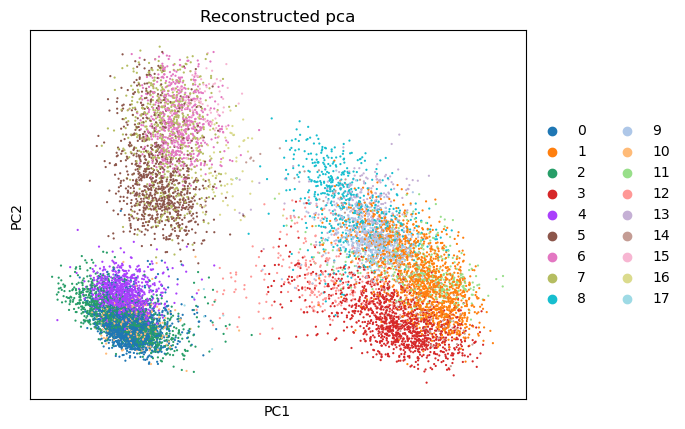

In [25]:
#================PCA========================#

sc.pp.pca(adata)
sc.pl.pca(adata, title ='adata pca', color = 'leiden')

sc.pp.pca(reconstructed_1)
sc.pl.pca(reconstructed_1, title = 'Reconstructed pca', color = 'leiden')

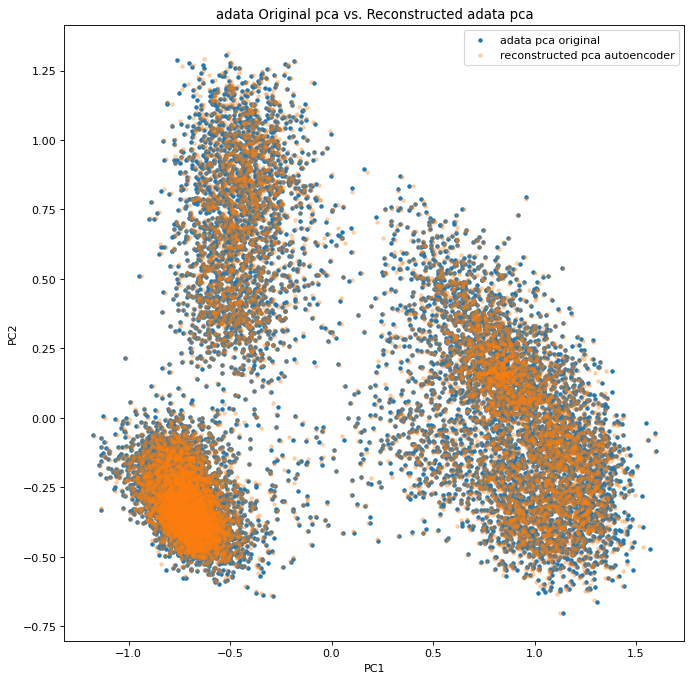

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

pca_original = np.array(pca.fit(adata.X))

pca_original = np.array(pca.transform(adata.X))

pca_reconstructed  = np.array(pca.fit(reconstructed_1.X))

pca_reconstructed  = np.array(pca.transform(reconstructed_1.X))

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_original[:,0],pca_original[:,1], marker = ".", alpha = 1, label = "adata pca original")
plt.scatter(pca_reconstructed[:,0], pca_reconstructed[:,1], marker = ".", alpha = 0.3, label = 'reconstructed pca autoencoder')
plt.title('adata Original pca vs. Reconstructed adata pca')
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.legend()

# View Reconstructed vs. Original UMAP 

In [1]:
# We want to integrate out data to plot leiden UMAP and show batches that is 'original data' and 'reference data'

# Save reconstructed data (adata_ref)
#adata_ref.write_h5ad('reconstructed_data.h5ad')

# Save original data (adata)
#adata.write_h5ad('original_data.h5ad')

In [31]:
path_original = '/u/project/cluo/chunter/original_data.h5ad'

path_reconstructed = '/u/project/cluo/chunter/reconstructed_data.h5ad'

adata_original = sc.read_h5ad(path_original)

adata_reconstructed = sc.read_h5ad(path_reconstructed)

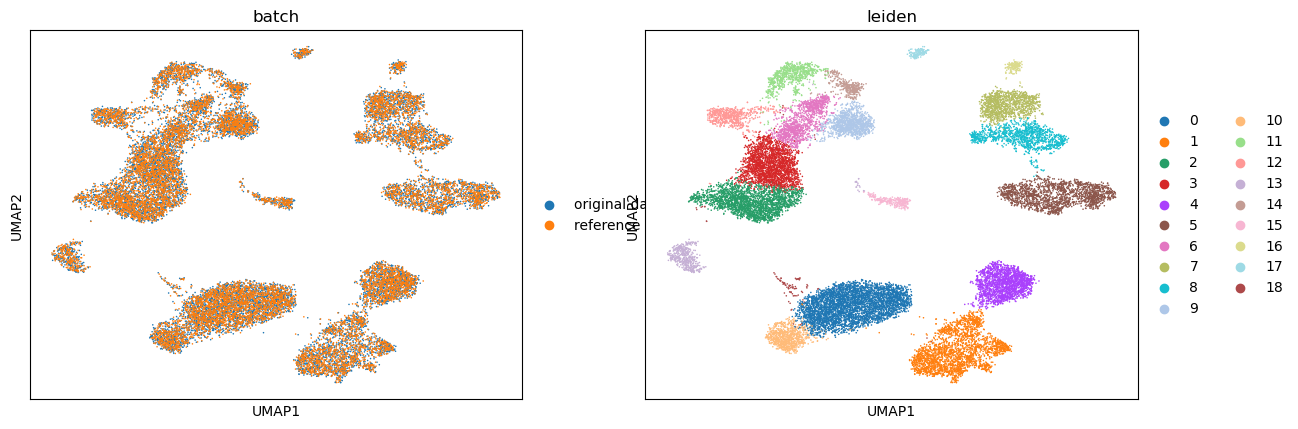

In [32]:
import anndata

adata_original.obs['batch'] = 'original data'
adata_reconstructed.obs['batch'] = 'reference data'

# Concatenate the datasets row-wise
merged_adata = anndata.concat([adata_original, adata_reconstructed], axis=0)

sc.pp.neighbors(merged_adata)

sc.tl.umap(merged_adata)

sc.tl.leiden(merged_adata)

sc.pl.umap(merged_adata, color=['batch'], legend_loc = 'left margin')

sc.pl.umap(merged_adata, color = ['leiden'], legend_loc = 'left margin')